/home/juan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


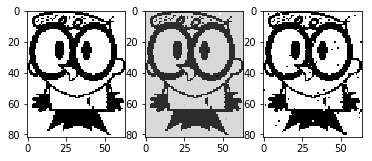

In [639]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import copy


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def binaryImage(image):
    cp_image = copy.deepcopy(image)
    for x in range(len(cp_image)):
        for y in range(len(cp_image[0])):
            cp_image[x][y] = round(cp_image[x][y])
    return cp_image
# proportion of pixels to alter

prop = 0.01
varSigma = 0.1
im = misc.imread('images/dexter.jpg')
im = im/255
im = binaryImage(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')
print(im)

In [437]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        return -1

In [569]:
def calculateEnergy(latent, noisy, i, j, beta, eta):
    n = neighbours(i, j, latent.shape[0], latent.shape[1])
    energy = eta*(latent[i][j]*noisy[i][j])
    for m in n:
        x, y = m
        energy += beta * latent[x][y] * latent[i][j]
    return energy

def convertLatent(latent):
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == 0:
                latent[i][j] = -1
    return latent
    
def ICM(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    latentImage = convertLatent(latentImage)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                if posEnergy > negEnergy:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

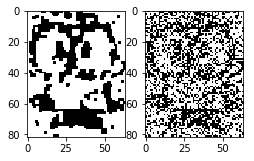

In [600]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im3, 0.4, 1, 5),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

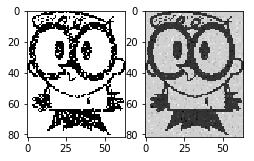

In [601]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im2, 0, 1, 5),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

In [547]:
def gibbs(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    latentImage = convertLatent(latentImage)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                latentImage[i][j] = 1
                posEnergy = np.exp(-calculateEnergy(latentImage, image, i, j, beta, eta))
                latentImage[i][j] = -1
                negEnergy = np.exp(-calculateEnergy(latentImage, image, i, j, beta, eta))
                joint = posEnergy/(posEnergy+negEnergy)
                r = np.random.uniform(0,1)
                if joint < r:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

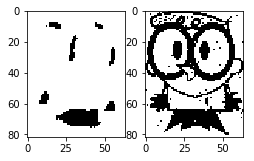

In [648]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbs(im3, 1, 1, 20),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')